In [395]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sudoku_solver import filter_image

%matplotlib inline



def line_intersect(A1, A2, B1, B2):
    # https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines-in-python
    def slope(P1, P2):
        return(P2[1] - P1[1]) / (P2[0] - P1[0])

    def y_intercept(P1, slope):
        return P1[1] - slope * P1[0]
   
    m1, m2 = slope(A1, A2), slope(B1, B2)
    if m1 == m2:
        print ("These lines are parallel!!!")
        return None
    
    b1, b2, = y_intercept(A1, m1), y_intercept(B1, m2)
    
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return x,y


def rho_theta_to_coords(line, image_shape=None):
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    return x1, y1, x2, y2

def nearest_neighbors(arr, values):
    res = []
#     vs = list(np.sort(values))
    vs = values
    thresholds = list((vs[i+1]+vs[i])/2 for i in range(len(vs)-1))
#     thresholds.insert(0, np.min(arr)*(1+np.finfo(type(arr[0])).eps))
    thresholds.insert(0, np.min(arr)-0.01)

#     print(np.finfo(type(arr[0])).epsneg, np.min(arr),
#           np.min(arr)*(1+np.finfo(type(arr[0])).eps),
#           np.min(arr)<np.min(arr)*(1+np.finfo(type(arr[0])).eps))
    thresholds.append(np.max(arr))
#     print(thresholds)
    for th_i in range(1, len(thresholds)):
#         print(thresholds[th_i-1], thresholds[th_i])
        indexes_1 = np.where(arr<=thresholds[th_i])[0]
        indexes_2 = np.where(arr>thresholds[th_i-1])[0]
        indexes = list(set(indexes_1).intersection(indexes_2))
        res.append(indexes)
    return res

def classify_by_theta(ls):
    thetas = np.array(list(line[0][1] for line in ls))
#     print(len(thetas))
    plt.hist(thetas)
    count, ths = np.histogram(thetas)
#     print(count)
#     print( np.argsort(count))
    th1, th2 = ths[((np.argsort(count))[::-1])[:2]]
#     print(th1, th2)

    thetas_1, thetas_2 = nearest_neighbors(thetas, [th1, th2])
    
    return ls[thetas_1], ls[thetas_2]

def filter_lines(ls):
    rhos = np.array(list(line[0][0] for line in ls))
    
    sorted_indexes = np.argsort(rhos)
    rhos = rhos[sorted_indexes]
    sorted_lines = ls[sorted_indexes]
#     print(len(rhos), rhos)
    ct = np.array(list(np.array([abs(rhos[i]-rhos[j]) for i in range(len(rhos)-1, j, -1)]) for j in range(len(rhos)-1)))
#     for i, _ in enumerate(ct):
#         print(i, _)
    res = []
    for i, l in enumerate(ct):
        if np.min(l)>25:
            res.append(i)
#         else:
#             print("delele", i)
    res.append(len(rhos)-1)
#     print("res", res)
#     print("rhos\n",rhos, "\n")
    classified_lines = nearest_neighbors(rhos, rhos[res])
#     print("classified_lines\n", classified_lines)
#     for _ in list(sorted_lines[inds] for inds in classified_lines):
#         print(_, "end")
    final_lines = list(np.average(sorted_lines[inds], axis=0) for inds in classified_lines)
#     print("test")
#     print(final_lines)
    return final_lines

In [392]:
path = "pics/test11.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE )

filtered_img = filter_image(img)
plt.figure(figsize=(10,10))
plt.imshow(filtered_img, cmap="gray")
plt.show()

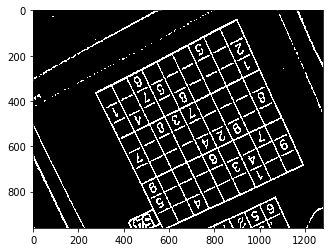

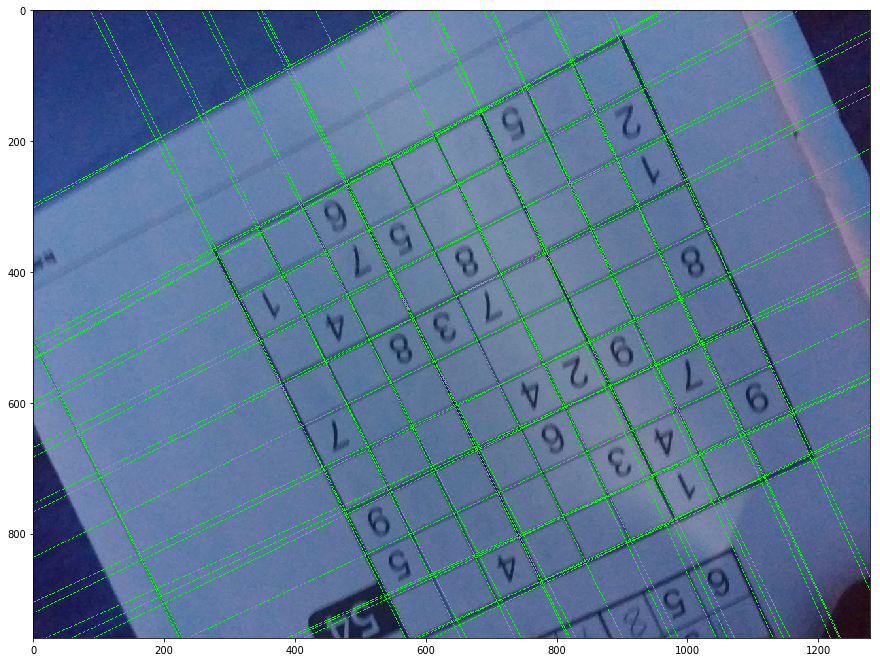

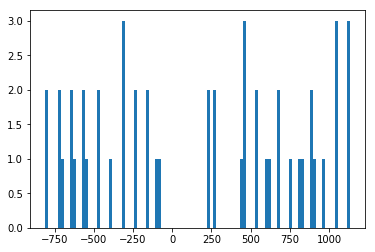

In [393]:
plt.imshow(filtered_img, cmap="gray")
plt.show()

lines = cv2.HoughLines(filtered_img, 1, np.pi/180, 30)
# lines = filter_lines(lines)

rgb_img = cv2.imread(path)
# rgb_img = np.ones((filtered_img.shape[0], filtered_img.shape[1], 3))
# for i in range(rgb_img.shape[0]):
#     for j in range(rgb_img.shape[1]):
#         rgb_img[i][j] = [filtered_img[i][j]]*3

lines = lines[:50]
for line in lines:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    
#     cv2.circle(rgb_img,(x1,y1), 1, (0,0,255), -1)
#     cv2.circle(rgb_img,(x2,y2), 1, (0,0,255), -1)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()

plt.hist(np.array(list(line[0][0] for line in lines)), bins=100)
plt.show()
plt.hist(np.array(list(line[0][1] for line in lines)))
plt.show()


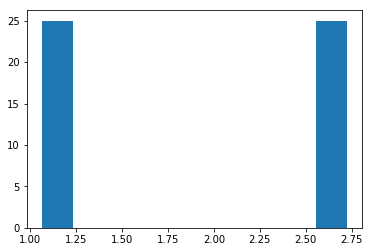

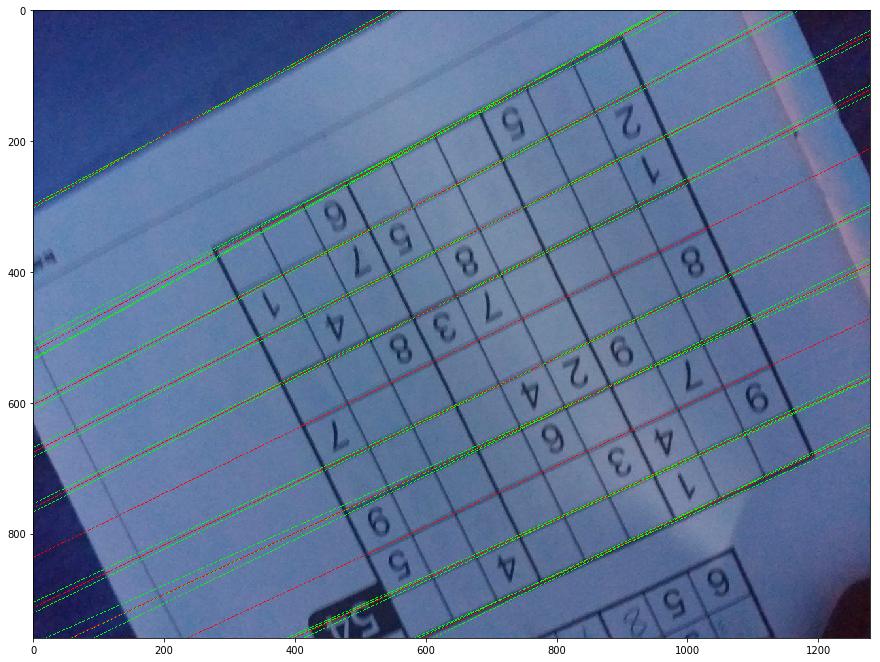

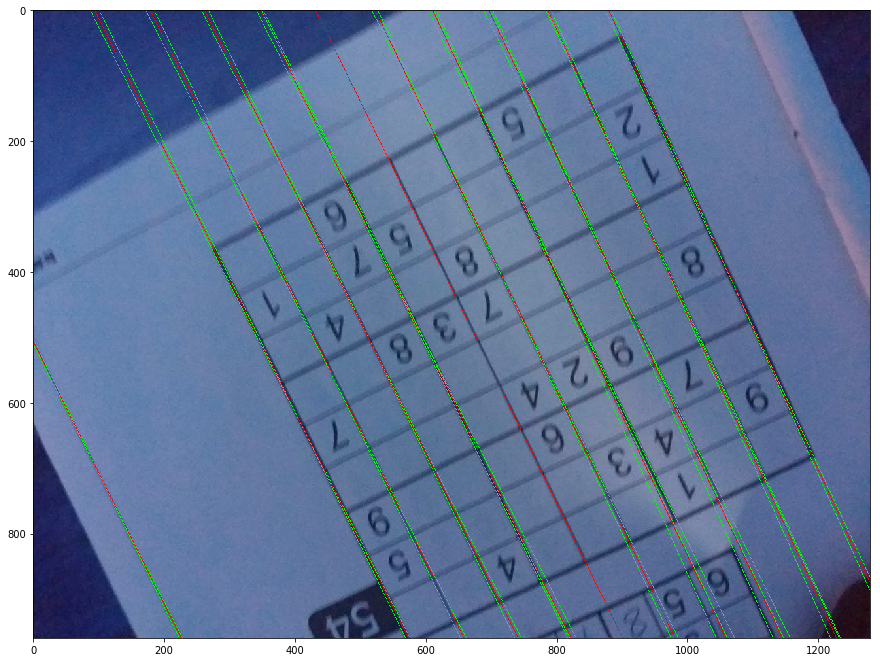

In [397]:
lines_1, lines_2 = classify_by_theta(lines)

rgb_img = cv2.imread(path)
for line in lines_1:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
for line in filter_lines(lines_1):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()


rgb_img = cv2.imread(path)
for line in lines_2:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
for line in filter_lines(lines_2):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()



# LINES_2

25 [-808. -794. -724. -713. -711. -643. -634. -620. -564. -556. -543. -478.
 -466. -389. -317. -314. -304. -241. -229. -167. -154.  -91.  -78.  220.
  232.]
0 [1040. 1028.  730.  717.  654.  641.  579.  567.  504.  494.  491.  419.
  342.  330.  265.  252.  244.  188.  174.  165.   97.   95.   84.   14.]
1 [1026. 1014.  716.  703.  640.  627.  565.  553.  490.  480.  477.  405.
  328.  316.  251.  238.  230.  174.  160.  151.   83.   81.   70.]
2 [956. 944. 646. 633. 570. 557. 495. 483. 420. 410. 407. 335. 258. 246.
 181. 168. 160. 104.  90.  81.  13.  11.]
3 [945. 933. 635. 622. 559. 546. 484. 472. 409. 399. 396. 324. 247. 235.
 170. 157. 149.  93.  79.  70.   2.]
4 [943. 931. 633. 620. 557. 544. 482. 470. 407. 397. 394. 322. 245. 233.
 168. 155. 147.  91.  77.  68.]
5 [875. 863. 565. 552. 489. 476. 414. 402. 339. 329. 326. 254. 177. 165.
 100.  87.  79.  23.   9.]
6 [866. 854. 556. 543. 480. 467. 405. 393. 330. 320. 317. 245. 168. 156.
  91.  78.  70.  14.]
7 [852. 840. 542. 529. 466

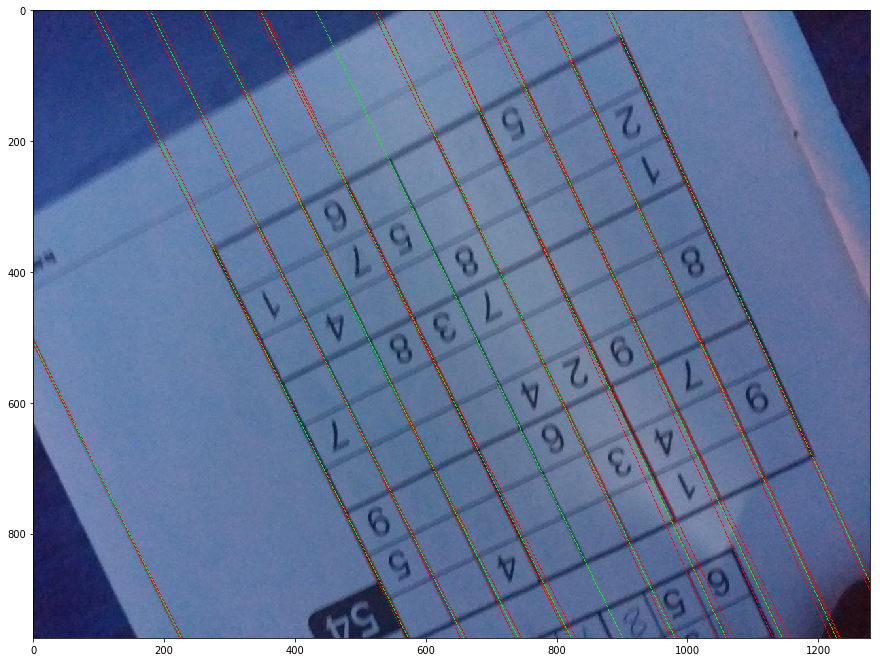

In [387]:

    
rgb_img = cv2.imread(path)

# l_s = np.array(sorted(lines_2, key=lambda x:x[0][0], reverse=True))
l_s = lines_2

for line in l_s:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
for line in filter_lines(l_s):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()

# LINES_1

22 [ 262.  449.  455.  531.  538.  600.  608.  677.  683.  751.  820.  827.
  884.  894.  903.  970. 1035. 1038. 1045. 1114. 1120. 1131.]
0 [869. 858. 852. 783. 776. 773. 708. 641. 632. 622. 565. 558. 489. 421.
 415. 346. 338. 276. 269. 193. 187.]
1 [682. 671. 665. 596. 589. 586. 521. 454. 445. 435. 378. 371. 302. 234.
 228. 159. 151.  89.  82.   6.]
2 [676. 665. 659. 590. 583. 580. 515. 448. 439. 429. 372. 365. 296. 228.
 222. 153. 145.  83.  76.]
3 [600. 589. 583. 514. 507. 504. 439. 372. 363. 353. 296. 289. 220. 152.
 146.  77.  69.   7.]
4 [593. 582. 576. 507. 500. 497. 432. 365. 356. 346. 289. 282. 213. 145.
 139.  70.  62.]
5 [531. 520. 514. 445. 438. 435. 370. 303. 294. 284. 227. 220. 151.  83.
  77.   8.]
6 [523. 512. 506. 437. 430. 427. 362. 295. 286. 276. 219. 212. 143.  75.
  69.]
7 [454. 443. 437. 368. 361. 358. 293. 226. 217. 207. 150. 143.  74.   6.]
8 [448. 437. 431. 362. 355. 352. 287. 220. 211. 201. 144. 137.  68.]
9 [380. 369. 363. 294. 287. 284. 219. 152. 143. 133.  

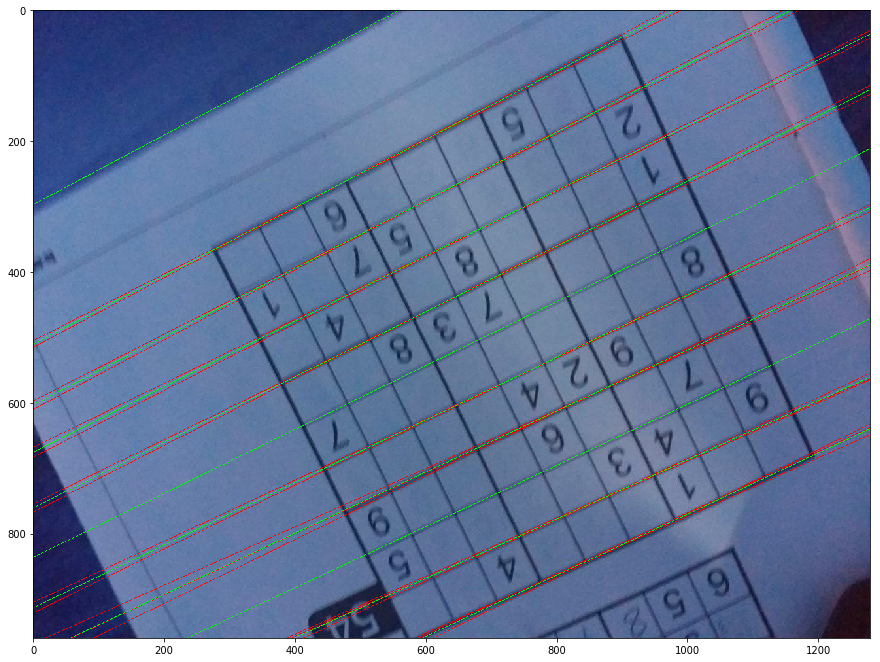

In [388]:
def filter_lines(ls):
    rhos = np.array(list(line[0][0] for line in ls))
    
    sorted_indexes = np.argsort(rhos)
    rhos = rhos[sorted_indexes]
    sorted_lines = ls[sorted_indexes]
    
    print(len(rhos), rhos)
    
    ct = np.array(list(np.array([abs(rhos[i]-rhos[j]) for i in range(len(rhos)-1, j, -1)]) for j in range(len(rhos)-1)))
    for i, _ in enumerate(ct):
        print(i, _)
    
    res = []
    for i, l in enumerate(ct):
        if np.min(l)>25:
            res.append(i)
#         else:
#             print("delele", i)
    res.append(len(rhos)-1)
    print("res", res)
    
    print("rhos\n",rhos, "\n")
    classified_lines = nearest_neighbors(rhos, rhos[res])
    print("classified_lines\n", classified_lines)
    for _ in list(sorted_lines[inds] for inds in classified_lines):
        print(_, "end")
    final_lines = list(np.average(sorted_lines[inds], axis=0) for inds in classified_lines)
    print("test")
    print(final_lines)
    return final_lines
    
rgb_img = cv2.imread(path)

# l_s = np.array(sorted(lines_2, key=lambda x:x[0][0], reverse=True))
l_s = lines_1

for line in l_s:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
for line in filter_lines(l_s):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()